In [2]:
import os
import torch
import torchvision
import cv2
import numpy as np
import torch.nn as nn
import torch.optim as optim
import matplotlib
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torchvision.utils as vutils
import torchvision.transforms as transforms
import argparse

from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

from imutils import paths
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from sklearn.utils import resample
from sklearn.metrics import classification_report

In [3]:
device = 'mps'
momentum = 0.9
num_epochs = 20
num_classes = 2 #fake & real 
val_size = 0.3
batch_size = 100
learn_rate = 0.001
freeze_lower_layers = True
data_path = "/Users/jillcakmak/Documents/GitHub/AI_Project/image_data"

In [4]:
train_transform = transforms.Compose(
    [
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomAffine(degrees=(-30,30),translate=(0.15,0.15),scale=(0.85,1.15)),
        transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5),
        transforms.RandomResizedCrop(size=(224, 224), antialias=True),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

In [5]:
val_transform = transforms.Compose(
    [   
        torchvision.transforms.Resize(224, antialias=True),
        torchvision.transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

In [6]:
#Splitting our data in training, validation and test 
dataset = ImageFolder(data_path, transform=train_transform)
num_classes = 2 #len(dataset.classes)

# Get length of dataset and indicies
num_train = len(dataset)
indices = list(range(num_train))

# Get train / val split for data points
train_indices, test_indices = train_test_split(indices, test_size=val_size, random_state=42)
train_indices, val_indices = train_test_split(train_indices, test_size=val_size, random_state=42)

# Override dataset classes to only be samples for each split
train_subset = torch.utils.data.Subset(dataset, train_indices)
test_subset = torch.utils.data.Subset(dataset, test_indices)
val_subset = torch.utils.data.Subset(dataset, val_indices)

# Create data loaders
train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_subset, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)

In [10]:
import torch
#model = torch.hub.load('pytorch/vision:v0.10.0', 'densenet121', pretrained=True) #I tried 121 but I did get an error, instead I will work with 169 now 
# or any of these variants
model = torch.hub.load('pytorch/vision:v0.10.0', 'densenet169', pretrained=True)
# model = torch.hub.load('pytorch/vision:v0.10.0', 'densenet201', pretrained=True)
# model = torch.hub.load('pytorch/vision:v0.10.0', 'densenet161', pretrained=True)
#model.eval()

Using cache found in /Users/jillcakmak/.cache/torch/hub/pytorch_vision_v0.10.0
/Applications/miniconda3/envs/AIM/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Applications/miniconda3/envs/AIM/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet169_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet169_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet169-b2777c0a.pth" to /Users/jillcakmak/.cache/torch/hub/checkpoints/densenet169-b2777c0a.pth
100%|██████████| 54.7M/54.7M [00:02<00:00, 26.3MB/s]


In [12]:
# Freeze weights
if freeze_lower_layers == True:
    for param in model.parameters():
        param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model.classifier.in_features #I had to change fc to classifier, I found the solution here: https://discuss.pytorch.org/t/pytorch-transfer-learning-with-densenet/15579/4
model.classifier = nn.Linear(num_ftrs, num_classes)
model.to(device)

#this code was originally sources from: https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html as described in class

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [13]:
#Now I will follow the code fromt class as I did previously 
criterion = nn.CrossEntropyLoss()

# Stochastic gradient descent loss
optimizer = optim.SGD(model.parameters(), lr=learn_rate, momentum=momentum)

In [15]:
#Training for 20 Epochs in Densenet 169
train_losses = []
val_losses = []

best_loss = 100000
for epoch in range(num_epochs): 
    train_loss = 0.0
    
    # Training loop
    for i, data in enumerate(train_loader, 0):
        # Get data
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        # Process data
        outputs = model(inputs)
        
        # Calculate loss
        loss = criterion(outputs, labels)
        
        # Update model weights
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        train_loss += loss.item()
    
    # Validation loop
    with torch.no_grad():
        val_loss = 0.0
        for i, data in enumerate(val_loader, 0):
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
    
    # Normalise cumulative losses to dataset size
    train_loss = train_loss / len(train_loader)
    val_loss = val_loss / len(val_loader)
    
    # Added cumulative losses to lists for later display
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    
    print(f'Epoch {epoch + 1}, train loss: {train_loss:.3f}, val loss: {val_loss:.3f}')
    
    # if validation score is lowest so far, save the model
    if val_loss < best_loss:
        best_loss = val_loss
        torch.save(model.state_dict(), 'best_finetuned_model_densenet161.pt')

Epoch 1, train loss: 0.710, val loss: 0.726
Epoch 2, train loss: 0.690, val loss: 0.697
Epoch 3, train loss: 0.693, val loss: 0.704
Epoch 4, train loss: 0.679, val loss: 0.685
Epoch 5, train loss: 0.680, val loss: 0.699
Epoch 6, train loss: 0.661, val loss: 0.714
Epoch 7, train loss: 0.681, val loss: 0.697
Epoch 8, train loss: 0.656, val loss: 0.688
Epoch 9, train loss: 0.654, val loss: 0.687
Epoch 10, train loss: 0.645, val loss: 0.692
Epoch 11, train loss: 0.655, val loss: 0.686
Epoch 12, train loss: 0.660, val loss: 0.720
Epoch 13, train loss: 0.658, val loss: 0.705
Epoch 14, train loss: 0.650, val loss: 0.688
Epoch 15, train loss: 0.648, val loss: 0.690
Epoch 16, train loss: 0.659, val loss: 0.665
Epoch 17, train loss: 0.669, val loss: 0.728
Epoch 18, train loss: 0.643, val loss: 0.685
Epoch 19, train loss: 0.641, val loss: 0.701
Epoch 20, train loss: 0.642, val loss: 0.670


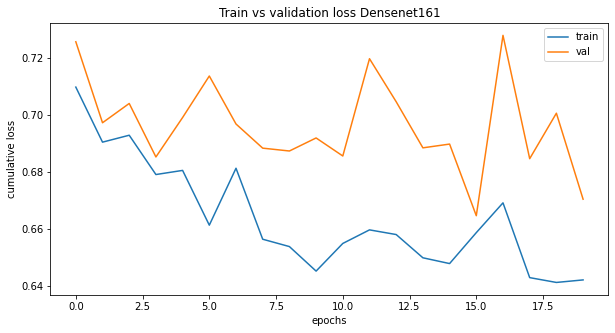

In [16]:
#Plotting Training and Validation loss 
plt.figure(figsize=(10,5))
plt.title("Train vs validation loss Densenet161")
plt.plot(train_losses,label="train")
plt.plot(val_losses,label="val")
plt.xlabel("epochs")
plt.ylabel("cumulative loss")
plt.legend()
plt.show()

In [17]:
    # Training loop from above now used to test  
total= 0
correct = 0

for i, data in enumerate(test_loader, 0):
        # Get data
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        # Process data
        outputs = model(inputs)

        # Compute predictions #this part is from chat-gpt 
        _, predicted = torch.max(outputs.data, 1)

         # Calculate accuracy
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

In [18]:
# Print the accuracy
print('Accuracy of the network on the test images: %d %%' % (100 * correct / total))

Accuracy of the network on the test images: 62 %


#### Accuracy of Densenet-169 of Model with 20 Epochs is 62% 
That is better but still not great for the classification we practice. Next we will check the outcome with 40 Epochs, will it be overtrained? 